In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import matplotlib as mpl    
mpl.rc('font',family='serif')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import seaborn as sns

import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.utils.fixes import signature

import pymc3 as pm

In [2]:
pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

df.dropna(inplace = True) # do to some unknown fuckery in the last script.. to fix later

In [3]:
pkl_file = open('dict_of_metrics_out_years20.pkl', 'rb')

dct_20 = pickle.load(pkl_file)

pkl_file.close()

In [4]:
y_test = df[df['year']>2005]['lead_binary_best']

In [5]:
preds = np.array(dct_20['preds1']).mean(0)
preds0 = np.array(dct_20['preds0']).mean(0)


# bayesian correction
#preds_bayes = (preds*0.2)/((preds*0.2)+(preds0*0.8)) # no change in ap but preferable

# full dist:
preds_bayes = (np.array(dct_20['preds1'])*0.2)/((np.array(dct_20['preds1'])*0.2)+(np.array(dct_20['preds0'])*0.8))

----

In [6]:
def prc(sample_size = 100, alpha = 0.01, fig_title = 'some_plot'):

    mean_ap = average_precision_score(y_test,  preds_bayes.mean(0))
    high_ap = np.percentile(np.array(dct_20['ap']),99.5)
    low_ap = np.percentile(np.array(dct_20['ap']),00.5)

    plt.figure(figsize=[9,9])


    for i in range(sample_size):
        preds_temp = preds_bayes[i]

        precision, recall, _ = precision_recall_curve(y_test,preds_temp)

        plt.plot(recall, precision, color='C0', alpha=alpha)

        #plt.fill_between(recall, precision, alpha=0.2, color='C0', **step_kwargs)

    preds_temp = preds_bayes.mean(0)

    precision, recall, _ = precision_recall_curve(y_test,preds_temp)

    plt.plot(recall, precision, color='C1', alpha=1)
    
    plt.title('Precision-Recall Curve', fontsize = 16)
    
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])

    sns.despine()

    cred_label = "Average precision 99% credibility interval: " + str(low_ap.round(3)) + '-' + str(high_ap.round(2))
    mean_label = 'Average precision point estimat (mean): ' + str(mean_ap.round(3))


    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

    mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

    plt.legend(handles=[mean_line, cred_line],frameon = False, fontsize = 14)
    
    fig_title = fig_title + '.pdf'
    
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()


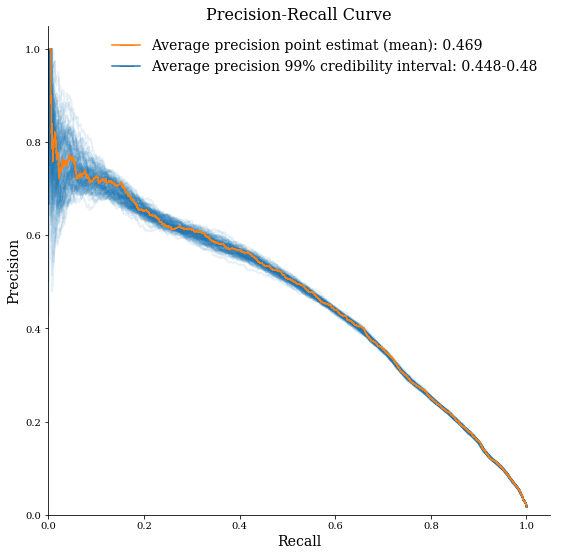

In [7]:
prc(100,0.1, 'pr_curve')

In [8]:
print(recall_score(y_test, preds_bayes.mean(0).round()))
print(precision_score(y_test, preds_bayes.mean(0).round()))

0.4416604338070307
0.5414947271893626


In [9]:
def metric_lists(sample_size = 100):

    recall_list50 = []
    for i in range(sample_size):
        recall_temp = recall_score(y_test, preds_bayes[i].round()) # 50/50 threshold
        recall_list50.append(recall_temp)

    precision_list50 = []
    for i in range(sample_size):
        precision_temp = precision_score(y_test, preds_bayes[i].round()) # 50/50 threshold
        precision_list50.append(precision_temp)
        
    recall_list25 = []
    for i in range(sample_size):
        recall_temp = recall_score(y_test, np.array(preds_bayes[i] > 0.25).astype(int)) # 50/50 threshold
        recall_list25.append(recall_temp)
    
    precision_list25 = []
    for i in range(sample_size):
        precision_temp = precision_score(y_test, np.array(preds_bayes[i] > 0.25).astype(int)) # 50/50 threshold
        precision_list25.append(precision_temp)

    recall_list75 = []
    for i in range(sample_size):
        recall_temp = recall_score(y_test, np.array(preds_bayes[i] > 0.75).astype(int)) # 50/50 threshold
        recall_list75.append(recall_temp)

    precision_list75 = []
    for i in range(sample_size):
        precision_temp = precision_score(y_test, np.array(preds_bayes[i] > 0.75).astype(int)) # 50/50 threshold
        precision_list75.append(precision_temp)
        
        
    recall_list10 = []
    for i in range(sample_size):
        recall_temp = recall_score(y_test, np.array(preds_bayes[i] > 0.1).astype(int)) # 50/50 threshold
        recall_list10.append(recall_temp)

    precision_list10 = []
    for i in range(sample_size):
        precision_temp = precision_score(y_test, np.array(preds_bayes[i] > 0.1).astype(int)) # 50/50 threshold
        precision_list10.append(precision_temp)

    return(recall_list10, recall_list25, recall_list50, recall_list75,
           precision_list10, precision_list25, precision_list50, precision_list75)

In [10]:
list_of_lists = metric_lists(1000)

In [11]:
def point_est(some_list):
    mean = np.array(some_list).mean()
    
    return(mean)

def all_point_est():
    
    list_of_means = []
    
    for i in list_of_lists:
        mean_temp = point_est(i)
        list_of_means.append(mean_temp)
        
    return(list_of_means)
    
list_of_means = all_point_est()

In [12]:
def threshold_plot(fig_title = 'some_plot'):    
    
    color_list = ['cyan', 'c', 'teal', 'darkslategray', 'lightsalmon','lightcoral', 'indianred', 'firebrick']
    
    label_list = ['racall (threshold = 0.10)','racall (threshold = 0.25)',
                  'racall (threshold = 0.50)','racall (threshold = 0.75)', 
                  'precision (threshold = 0.10)', 'precision (threshold = 0.25)',
                  'precision (threshold = 0.50)','precision (threshold = 0.75)']

    for i in range(len(list_of_lists)):

        kde_temp = sns.kdeplot(list_of_lists[i], color = color_list[i], label = label_list[i])

        kde_max = kde_temp.lines[i].get_data()[1].max()

        plt.scatter(list_of_means[i], kde_max, s = 100, alpha = 0.5, color = color_list[i])

        plt.annotate(list_of_means[i].round(3), xy = (list_of_means[i]+0.01, kde_max) )

    plt.title('Prcision and Recall at Various Thresholds', fontsize = 16)
    plt.xlim(0,1)
    plt.xlabel('metric score', fontsize = 14)

    plt.yticks([])

    sns.despine(left = True)
    plt.legend(loc = 2, frameon=False)

    fig_title = fig_title + '.pdf'
    
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()


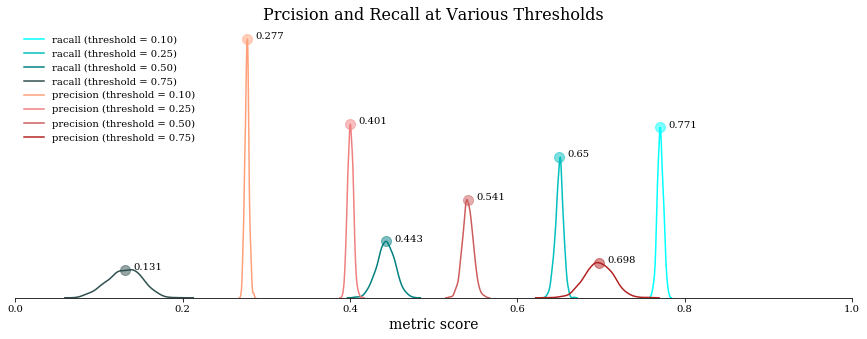

In [13]:
threshold_plot('threshold_plot')

-----
# MAPS

In [14]:
df_test_years = df[df['year']>2005].copy()

In [15]:
df_test_years.shape

(253548, 62)

In [16]:
preds_bayes.shape

(1000, 253548)

In [17]:
df_test_years['pred_lead_prob_best20'] = preds
df_test_years['pred_lead_prob_best20_baysian'] = preds_bayes.mean(0)

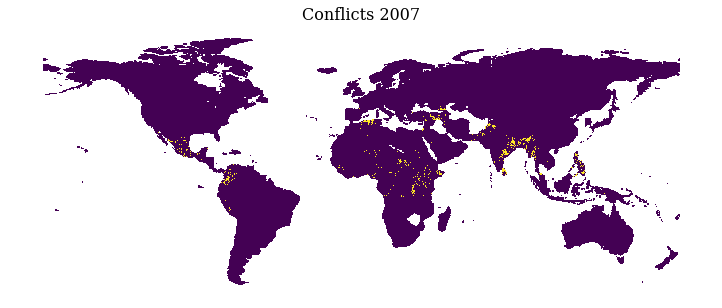

In [18]:
df_test_years[df_test_years['year']==2006].plot(column = 'lead_binary_best')

plt.title('Conflicts 2007', fontsize = 16)

sns.despine(left = True, bottom = True)

plt.xticks([])
plt.yticks([])

fig_title = 'conflicts_2007.pdf'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

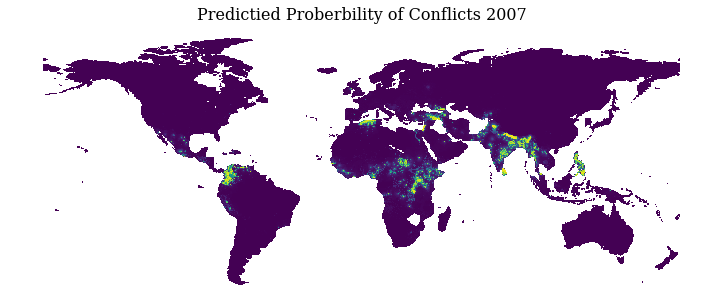

In [19]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20')

plt.title('Predictied Proberbility of Conflicts 2007', fontsize = 16)

sns.despine(left = True, bottom = True)

plt.xticks([])
plt.yticks([])

fig_title = 'pred_prob_conflicts_2007.pdf'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

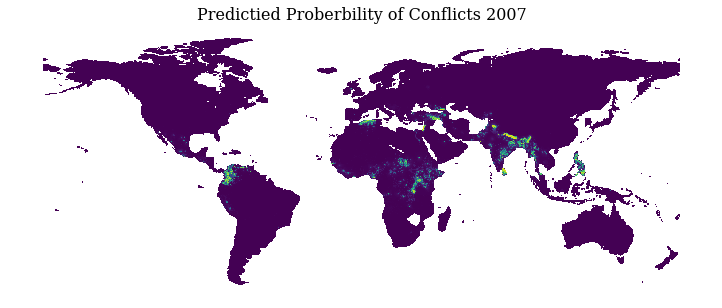

In [20]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20_baysian')

plt.title('Predictied Proberbility of Conflicts 2007', fontsize = 16)

sns.despine(left = True, bottom = True)

plt.xticks([])
plt.yticks([])

fig_title = 'pred_prob_conflicts_2007_bayes.pdf'
plt.savefig(fig_title, bbox_inches="tight")

plt.show()

------
# Feature Importance

In [21]:
def feature_imp_plot(dict_of_metrics, fig_title = 'some_fig.pdf'):
    
#     X_labels = ['past_fatalities', 'fatilities_country_year', 'nearest_conflict','past_conflicts',
#                 'landarea','country_area_sum',
#                 'interp_pop_gpw_sum','country_pop_sum',         
#                 'light_capita_cell','light_capita_country',
#                 'low_ratio_light', 'diff_median_light',
#                 'mountains_mean', 'ttime_mean', 'capdist',
#                 'bdist1',
#                 'excluded_binary',
#                 'petroleum_full']


    X_labels = ['All past fatalities \nin cell', 'Fatilities in country \n(year = t)',
                'Distance to nearest conflict \n(year = t)', 'Number of past conflicts',
                'Area of the cell','Area of the country',
                'Cell population','Country population',         
                'Cell wealth \n(night light) per capita','Country wealth \n(night light) per capita',
                'Relative deprivation \n(low ratio)', 'Relative deprevation \n(cell/country median diff.)',
                'Mountains', 'Travel Time to \nmajor city', 'Distance to country capital',
                'Distance to border',
                'Excluded ethnicities \n(binary)',
                'Oil deposits \n(binary)']



    #importances = xg_cl.feature_importances_
    importances = np.array(dict_of_metrics['feature_imp']).mean(0)
    importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


    indices = np.argsort(importances)[::-1]

    size = len(importances)

    plt.figure(figsize=[10,int(size)*0.75])

    plt.title("Feature importances", fontsize = 16)


    plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

    plt.yticks(range(size),  np.array(X_labels)[indices], fontsize = 14)
    plt.ylim([-1, size])

    plt.xlabel('gain', fontsize = 14)
    #plt.ylabel('features', fontsize = 14)

    sns.despine()
    
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

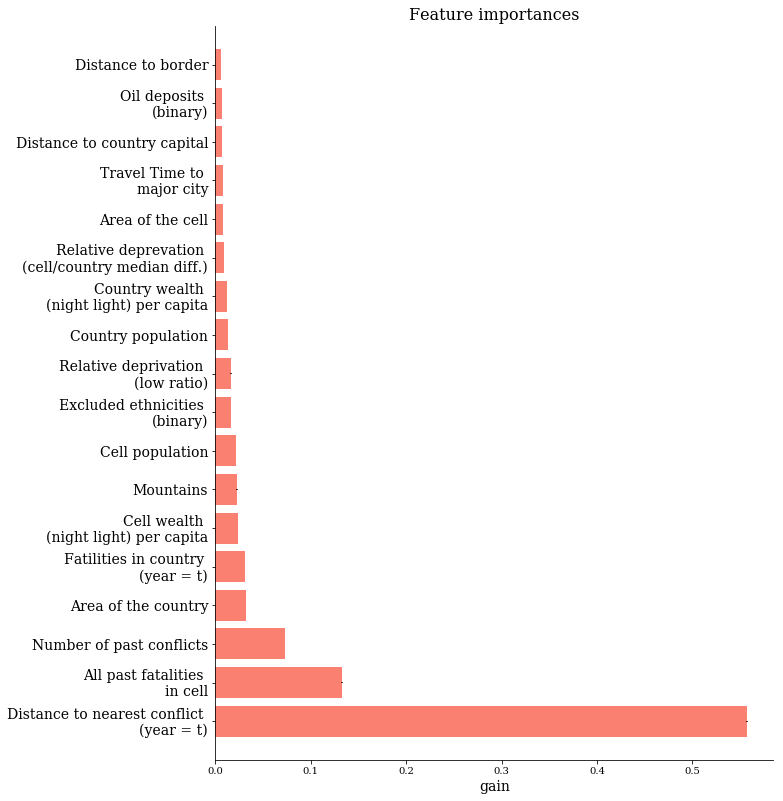

In [22]:
feature_imp_plot(dct_20, 'feature_imp.pdf')